# Data Preprocessing

## Load the dataset

In [1]:
import pandas as pd

df = pd.read_csv("data.csv", sep=";", dtype={'BillNo': str})

In [2]:
print(df.head())

   BillNo                             Itemname  Quantity              Date  \
0  536365   WHITE HANGING HEART T-LIGHT HOLDER         6  01.12.2010 08:26   
1  536365                  WHITE METAL LANTERN         6  01.12.2010 08:26   
2  536365       CREAM CUPID HEARTS COAT HANGER         8  01.12.2010 08:26   
3  536365  KNITTED UNION FLAG HOT WATER BOTTLE         6  01.12.2010 08:26   
4  536365       RED WOOLLY HOTTIE WHITE HEART.         6  01.12.2010 08:26   

  Price  CustomerID         Country  
0  2,55     17850.0  United Kingdom  
1  3,39     17850.0  United Kingdom  
2  2,75     17850.0  United Kingdom  
3  3,39     17850.0  United Kingdom  
4  3,39     17850.0  United Kingdom  


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB


## Data Cleaning

In [4]:
df.drop_duplicates(inplace=True)

# Count negative quantity rows
neg_qty_rows = df[df['Quantity'] < 0]
print("Total rows with negative Quantity: ", len(neg_qty_rows))
print(neg_qty_rows.head())

# Keep only positive quantity rows
df = df[df['Quantity'] >= 0]



Total rows with negative Quantity:  1336
      BillNo Itemname  Quantity              Date Price  CustomerID  \
2359  536589      NaN       -10  01.12.2010 16:50     0         NaN   
4289  536764      NaN       -38  02.12.2010 14:42     0         NaN   
6998  536996      NaN       -20  03.12.2010 15:30     0         NaN   
6999  536997      NaN       -20  03.12.2010 15:30     0         NaN   
7000  536998      NaN        -6  03.12.2010 15:30     0         NaN   

             Country  
2359  United Kingdom  
4289  United Kingdom  
6998  United Kingdom  
6999  United Kingdom  
7000  United Kingdom  


## Handle Missing Values

In [5]:
print("MISSING VALUES")
print(df.isnull().sum())

MISSING VALUES
BillNo             0
Itemname         592
Quantity           0
Date               0
Price              0
CustomerID    132631
Country            0
dtype: int64


In [6]:
df.dropna(subset=["CustomerID", "Itemname"], inplace=True)

## Cleaned Data

In [7]:
# Keep only specified columns
df = df[['BillNo', 'CustomerID', 'Itemname', 'Quantity']]

print(df.head(10))


   BillNo  CustomerID                             Itemname  Quantity
0  536365     17850.0   WHITE HANGING HEART T-LIGHT HOLDER         6
1  536365     17850.0                  WHITE METAL LANTERN         6
2  536365     17850.0       CREAM CUPID HEARTS COAT HANGER         8
3  536365     17850.0  KNITTED UNION FLAG HOT WATER BOTTLE         6
4  536365     17850.0       RED WOOLLY HOTTIE WHITE HEART.         6
5  536365     17850.0         SET 7 BABUSHKA NESTING BOXES         2
6  536365     17850.0    GLASS STAR FROSTED T-LIGHT HOLDER         6
7  536366     17850.0               HAND WARMER UNION JACK         6
8  536366     17850.0            HAND WARMER RED POLKA DOT         6
9  536367     13047.0        ASSORTED COLOUR BIRD ORNAMENT        32


# Clustering Analysis 

## Build Basket

In [8]:
# (row = CustomerID, column = Itemname)
basket = df.groupby(['CustomerID', 'Itemname'])['Quantity'].sum().unstack().fillna(0)

## Convert Quantities to T/F (presence/absence)

In [9]:
customer_coded = basket > 0

## Implement KMeans algorithm

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MaxAbsScaler

X = customer_coded.drop(columns=["Cluster"], errors="ignore")
X = MaxAbsScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
labels = kmeans.fit_predict(X)

customer_coded["Cluster"] = labels
print(customer_coded["Cluster"].value_counts().sort_index())


Cluster
0      48
1     773
2    3476
Name: count, dtype: int64


## Top Products per Cluster

In [11]:
for c in sorted(customer_coded['Cluster'].unique()):
    cluster_data = customer_coded[customer_coded['Cluster'] == c].drop('Cluster', axis=1)
    top_items = cluster_data.sum().sort_values(ascending=False).head(10)
    
    print("\nCluster", c)
    print("Number of customers:", len(cluster_data))
    print("Top products:\n", top_items)


Cluster 0
Number of customers: 48
Top products:
 Itemname
LUNCH BAG SPACEBOY DESIGN             41
LUNCH BAG RED RETROSPOT               41
LUNCH BAG  BLACK SKULL.               39
LUNCH BAG CARS BLUE                   38
LUNCH BAG ALPHABET DESIGN             37
WHITE HANGING HEART T-LIGHT HOLDER    36
PACK OF 72 RETROSPOT CAKE CASES       36
LUNCH BAG VINTAGE LEAF DESIGN         36
LUNCH BAG PINK POLKADOT               36
LUNCH BAG WOODLAND                    35
dtype: int64

Cluster 1
Number of customers: 773
Top products:
 Itemname
JUMBO BAG RED RETROSPOT               318
REGENCY CAKESTAND 3 TIER              315
WHITE HANGING HEART T-LIGHT HOLDER    301
PACK OF 72 RETROSPOT CAKE CASES       296
LUNCH BAG RED RETROSPOT               293
SET OF 3 CAKE TINS PANTRY DESIGN      292
SPOTTY BUNTING                        284
PAPER CHAIN KIT 50'S CHRISTMAS        279
PARTY BUNTING                         272
JAM MAKING SET PRINTED                263
dtype: int64

Cluster 2
Number of cust

## Clusters (PCA Projection)

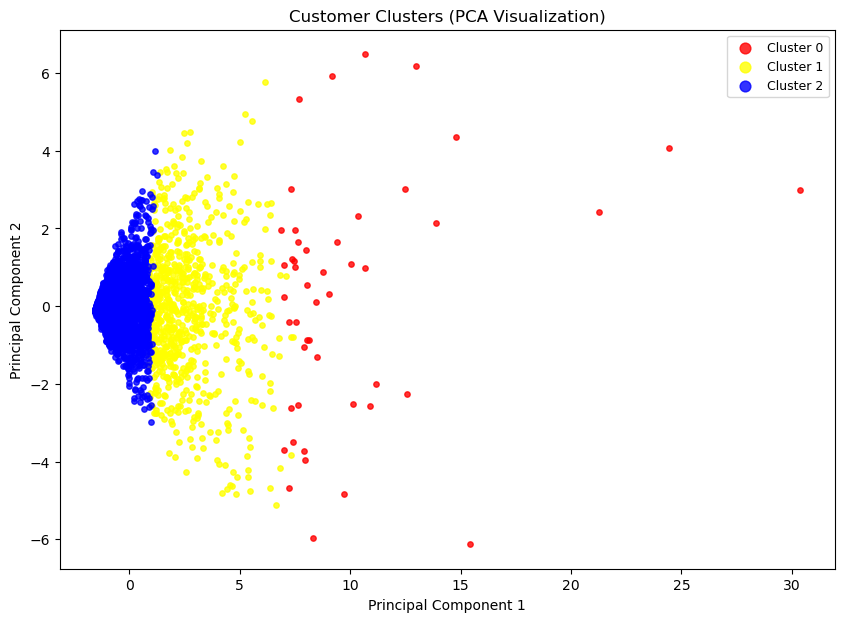

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca_vis = pca.fit_transform(X)

cluster_colors = {0: "red", 1: "yellow", 2: "blue"}

plt.figure(figsize=(10, 7))
for cluster_id, color in cluster_colors.items():
    mask = customer_coded["Cluster"] == cluster_id
    plt.scatter(
        X_pca_vis[mask, 0],
        X_pca_vis[mask, 1],
        color=color,
        s=15,
        alpha=0.8,
        label=f"Cluster {cluster_id}"
    )

plt.title("Customer Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(markerscale=2, fontsize=9)
plt.show()


# Market Basket Analysis Implementation

## Build basket

In [13]:
baskets = {}
# Loop through each cluster
for c in sorted(customer_coded["Cluster"].unique()):
    cluster_customers = customer_coded[customer_coded["Cluster"] == c].index
    cluster_df = df[df["CustomerID"].isin(cluster_customers)]
    
    # Build the basket (BillNo, Itemname)
    basket = (cluster_df.groupby(["BillNo", "Itemname"])["Quantity"].sum().unstack().fillna(0))
    
    # Convert to True/False 
    basket_tf = basket > 0
    baskets[c] = basket_tf

## Frequent Itemsets

In [14]:
from mlxtend.frequent_patterns import fpgrowth

min_sup = 0.015
frequent_itemsets_by_cluster = {}

for c in sorted(baskets.keys()):
    frequent_itemsets = fpgrowth(
        baskets[c],            
        min_support=min_sup,
        use_colnames=True
    )

    frequent_itemsets_by_cluster[c] = frequent_itemsets  

    print(f"Cluster {c} Frequent Itemsets (min_sup = 0.015)")
    print(frequent_itemsets.head(10).to_string(index=False))
    print("Total itemsets:", len(frequent_itemsets))
    print("------------------------------------------------------------")


Cluster 0 Frequent Itemsets (min_sup = 0.015)
 support                             itemsets
0.103376  (JUMBO SHOPPER VINTAGE RED PAISLEY)
0.076653    (RETROSPOT TEA SET CERAMIC 11 PC)
0.073136        (GIN + TONIC DIET METAL SIGN)
0.068917     (PAPER CHAIN KIT 50'S CHRISTMAS)
0.066807          (COOK WITH WINE METAL SIGN)
0.061181          (EDWARDIAN PARASOL NATURAL)
0.055556 (WHITE SPOT RED CERAMIC DRAWER KNOB)
0.052743      (RED TOADSTOOL LED NIGHT LIGHT)
0.048523 (DOORMAT FANCY FONT HOME SWEET HOME)
0.046414            (EDWARDIAN PARASOL BLACK)
Total itemsets: 7351
------------------------------------------------------------
Cluster 1 Frequent Itemsets (min_sup = 0.015)
 support                            itemsets
0.090648     (ASSORTED COLOUR BIRD ORNAMENT)
0.048275          (HOME BUILDING BLOCK WORD)
0.035866               (DOORMAT NEW ENGLAND)
0.034352          (LOVE BUILDING BLOCK WORD)
0.031326 (FELTCRAFT PRINCESS CHARLOTTE DOLL)
0.027240         (POPPY'S PLAYHOUSE KITCHEN)
0.025

## Generate Association Rules

In [15]:
from mlxtend.frequent_patterns import association_rules

CONF_THRESH = 0.3  
rules_by_cluster = {}

for c in sorted(frequent_itemsets_by_cluster.keys()):
    fi = frequent_itemsets_by_cluster[c]
    rules = association_rules(fi, metric="confidence", min_threshold=CONF_THRESH)
    rules = rules[rules["lift"] > 1]  # filter out weak rules

    rules_by_cluster[c] = rules

    print(f"Cluster {c} Association Rules (conf ≥ 0.3, lift > 1)")
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10).to_string(index=False))
    print("Total rules:", len(rules))
    print("------------------------------------------------------------")


Cluster 0 Association Rules (conf ≥ 0.3, lift > 1)
                                                 antecedents                         consequents  support  confidence     lift
                                   (JUMBO BAG RED RETROSPOT) (JUMBO SHOPPER VINTAGE RED PAISLEY) 0.054852    0.382353 3.698679
                         (JUMBO SHOPPER VINTAGE RED PAISLEY)           (JUMBO BAG RED RETROSPOT) 0.054852    0.530612 3.698679
                                    (JUMBO STORAGE BAG SUKI) (JUMBO SHOPPER VINTAGE RED PAISLEY) 0.043601    0.380368 3.679479
                         (JUMBO SHOPPER VINTAGE RED PAISLEY)            (JUMBO STORAGE BAG SUKI) 0.043601    0.421769 3.679479
                                   (JUMBO BAG PINK POLKADOT) (JUMBO SHOPPER VINTAGE RED PAISLEY) 0.043601    0.392405 3.795918
                         (JUMBO SHOPPER VINTAGE RED PAISLEY)           (JUMBO BAG PINK POLKADOT) 0.043601    0.421769 3.795918
                         (JUMBO SHOPPER VINTAGE RED PAISLEY)

## Sort association rules based on lift and confidence and outputs to CSV

In [16]:
for c, rules in rules_by_cluster.items():

    # Sort by lift and confidence 
    rules_sorted = rules.sort_values(by=['lift', 'confidence'], ascending=False)
    rules_by_cluster[c] = rules_sorted  

    print(f"Cluster {c} Rules Sorted by lift & confidence")
    print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5).to_string(index=False))
    print("Total rules:", len(rules_sorted))
    print("------------------------------------------------------------")

    file_name = f"cluster{c}_rules_sorted.csv"
    rules_sorted.to_csv(file_name, index=False)



Cluster 0 Rules Sorted by lift & confidence
                                                            antecedents                                                             consequents  support  confidence      lift
                                  (DISCO BALL ROTATOR BATTERY OPERATED)                                                   (MIRRORED DISCO BALL) 0.016878    0.857143 43.530612
                                                  (MIRRORED DISCO BALL)                                   (DISCO BALL ROTATOR BATTERY OPERATED) 0.016878    0.857143 43.530612
       (SMALL MARSHMALLOWS PINK BOWL, GARDENERS KNEELING PAD KEEP CALM) (SMALL DOLLY MIX DESIGN ORANGE BOWL, GARDENERS KNEELING PAD CUP OF TEA) 0.015471    0.814815 41.380952
(SMALL DOLLY MIX DESIGN ORANGE BOWL, GARDENERS KNEELING PAD CUP OF TEA)        (SMALL MARSHMALLOWS PINK BOWL, GARDENERS KNEELING PAD KEEP CALM) 0.015471    0.785714 41.380952
           (HERB MARKER THYME, HERB MARKER CHIVES, HERB MARKER PARSLEY)          